In [1]:
import numpy as np  # this module handles arrays, but here we need it for its NaN value
import pandas as pd # this module contains a lot of tools for handling tabular data
from matplotlib import pyplot as plt
from salishsea_tools import evaltools as et
import datetime as dt
import gsw
import pickle
import netCDF4 as nc
import cmocean
from scipy import stats as spst
%matplotlib inline

In [2]:
# define paths to the source files and eventual output file
flist=('/ocean/eolson/MEOPAR/obs/Nina/bottlePhytoMerged2015.csv',
       '/ocean/eolson/MEOPAR/obs/Nina/bottlePhytoMerged2016.csv',
       '/ocean/eolson/MEOPAR/obs/Nina/bottlePhytoMerged2017.csv',
       '/ocean/eolson/MEOPAR/obs/Nina/bottlePhytoMerged2018.csv')

In [3]:
# define conversion factors
Chl_N=1.8

In [4]:
dfs=list()
for fname in flist:
    idf=pd.read_csv(fname)
    print(fname,sorted(idf.keys()))
    dfs.append(idf)
df=pd.concat(dfs,ignore_index=True,sort=False) # concatenate the list into a single table

/ocean/eolson/MEOPAR/obs/Nina/bottlePhytoMerged2015.csv ['ADM:SCIENTIST', 'Chlorophyll:Extracted', 'Cruise', 'Cryptophytes', 'Cyanobacteria', 'Diatoms-1', 'Diatoms-2', 'Dictyo', 'Dinoflagellates-1', 'FIL:START TIME YYYY/MM/DD HH:MM:SS', 'File Name', 'Flag:Chlorophyll:Extracted', 'Flag:Nitrate_plus_Nitrite', 'Flag:Oxygen:Dissolved', 'Flag:Phosphate', 'Flag:Salinity:Bottle', 'Flag:Silicate', 'Fluorescence:URU:Seapoint', 'Haptophytes', 'LOC:EVENT_NUMBER', 'LOC:STATION', 'LOC:WATER DEPTH', 'Lat', 'Lon', 'Nitrate_plus_Nitrite', 'Number_of_bin_records', 'Oxygen:Dissolved', 'Oxygen:Dissolved:CTD', 'PAR', 'Phaeo-Pigment:Extracted', 'Phosphate', 'Prasinophytes', 'Pressure', 'Raphido', 'Salinity', 'Salinity:Bottle', 'Sample_Number', 'Silicate', 'TchlA (ug/L)', 'Temperature', 'Temperature:Draw', 'Transmissivity', 'Zone', 'pH:SBE:Nominal']
/ocean/eolson/MEOPAR/obs/Nina/bottlePhytoMerged2016.csv ['ADM:PROJECT', 'ADM:SCIENTIST', 'Bottle:Firing_Sequence', 'Bottle_Number', 'Chlorophyll:Extracted [mg/m

In [5]:
df.drop(labels=['ADM:MISSION','ADM:PROJECT','ADM:SCIENTIST','Zone','Zone.1','Temperature:Draw',
                'Temperature:Draw [deg C (ITS90)]','Bottle:Firing_Sequence','Comments by sample_numbeR',
                'File Name','LOC:EVENT_NUMBER','Number_of_bin_records'
                   ],axis=1,inplace=True)

In [6]:
for el in sorted(df.keys()):
    print(el)
    #if not el.startswith('ADM') and not el.startswith('Flag') and not el.startswith('LOC') \
     #and not el.startswith('Bottle'):
        #print(el)

Alkalinity:Total [umol/L]
Bottle_Number
Carbon:Dissolved:Inorganic [umol/kg]
Chlorophyll:Extracted
Chlorophyll:Extracted [mg/m^3]
Cruise
Cryptophytes
Cyanobacteria
Depth [metres]
Depth:Nominal [metres]
Diatoms-1
Diatoms-2
Dictyo
Dictyochophytes
Dinoflagellates
Dinoflagellates-1
FIL:START TIME YYYY/MM/DD HH:MM:SS
Flag:Alkalinity:Total
Flag:Carbon:Dissolved:Inorganic
Flag:Chlorophyll:Extracted
Flag:Nitrate_plus_Nitrite
Flag:Oxygen:Dissolved
Flag:Phosphate
Flag:Salinity:Bottle
Flag:Silicate
Fluorescence [mg/m^3]
Fluorescence:URU:Seapoint
Fluorescence:URU:Seapoint [mg/m^3]
Haptophytes
LOC:LATITUDE
LOC:LONGITUDE
LOC:STATION
LOC:WATER DEPTH
Lat
Lon
Nitrate_plus_Nitrite
Nitrate_plus_Nitrite [umol/L]
Oxygen:Dissolved
Oxygen:Dissolved [mL/L]
Oxygen:Dissolved [umol/kg]
Oxygen:Dissolved:CTD
Oxygen:Dissolved:CTD [mL/L]
Oxygen:Dissolved:CTD [umol/kg]
Oxygen:Dissolved:SBE [mL/L]
Oxygen:Dissolved:SBE [umol/kg]
PAR
PAR [uE/m^2/sec]
PAR:Reference [uE/m^2/sec]
Phaeo-Pigment:Extracted
Phaeo-Pigment:Extra

In [7]:
def subval(idf,colList):
    # first value in colList should be the column you are going to keep
    # follow with other columns that will be used to fill in when that column is NaN
    # in order of precedence
    if len(colList)==2:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] for i,r in idf.iterrows()]
    elif len(colList)==3:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] if not pd.isna(r[colList[1]]) \
                         else r[colList[2]] for i,r in idf.iterrows()]
    else:
        raise NotImplementedError('Add to code to handle this case')
    idf.drop(columns=list(colList[1:]),inplace=True)
    return idf

In [8]:
df=subval(df,('Dictyochophytes','Dictyo'))
df=subval(df,('Chlorophyll:Extracted [mg/m^3]','Chlorophyll:Extracted'))
df=subval(df,('Dinoflagellates','Dinoflagellates-1'))
df=subval(df,('Fluorescence [mg/m^3]','Fluorescence:URU:Seapoint [mg/m^3]','Fluorescence:URU:Seapoint'))
df=subval(df,('Lat','LOC:LATITUDE'))
df=subval(df,('Lon','LOC:LONGITUDE'))
df=subval(df,('Nitrate_plus_Nitrite [umol/L]','Nitrate_plus_Nitrite'))
df=subval(df,('PAR [uE/m^2/sec]','PAR'))
df=subval(df,('Phaeo-Pigment:Extracted [mg/m^3]','Phaeo-Pigment:Extracted'))
df=subval(df,('Phosphate [umol/L]','Phosphate'))
df=subval(df,('Pressure [decibar]','Pressure'))
df=subval(df,('Raphidophytes','Raphido'))
df=subval(df,('Salinity','Salinity [PSS-78]','Salinity:T1:C1 [PSS-78]'))
df=subval(df,('Salinity:Bottle','Salinity:Bottle [PSS-78]'))
df=subval(df,('Silicate [umol/L]','Silicate'))
df=subval(df,('TchlA (ug/L)','TchlA'))
df=subval(df,('Temperature','Temperature [deg C (ITS90)]','Temperature:Secondary [deg C (ITS90)]'))
df=subval(df,('Transmissivity [*/metre]','Transmissivity'))

In [9]:
print(sorted(df.keys()))

['Alkalinity:Total [umol/L]', 'Bottle_Number', 'Carbon:Dissolved:Inorganic [umol/kg]', 'Chlorophyll:Extracted [mg/m^3]', 'Cruise', 'Cryptophytes', 'Cyanobacteria', 'Depth [metres]', 'Depth:Nominal [metres]', 'Diatoms-1', 'Diatoms-2', 'Dictyochophytes', 'Dinoflagellates', 'FIL:START TIME YYYY/MM/DD HH:MM:SS', 'Flag:Alkalinity:Total', 'Flag:Carbon:Dissolved:Inorganic', 'Flag:Chlorophyll:Extracted', 'Flag:Nitrate_plus_Nitrite', 'Flag:Oxygen:Dissolved', 'Flag:Phosphate', 'Flag:Salinity:Bottle', 'Flag:Silicate', 'Fluorescence [mg/m^3]', 'Haptophytes', 'LOC:STATION', 'LOC:WATER DEPTH', 'Lat', 'Lon', 'Nitrate_plus_Nitrite [umol/L]', 'Oxygen:Dissolved', 'Oxygen:Dissolved [mL/L]', 'Oxygen:Dissolved [umol/kg]', 'Oxygen:Dissolved:CTD', 'Oxygen:Dissolved:CTD [mL/L]', 'Oxygen:Dissolved:CTD [umol/kg]', 'Oxygen:Dissolved:SBE [mL/L]', 'Oxygen:Dissolved:SBE [umol/kg]', 'PAR [uE/m^2/sec]', 'PAR:Reference [uE/m^2/sec]', 'Phaeo-Pigment:Extracted [mg/m^3]', 'Phosphate [umol/L]', 'Prasinophytes', 'Pressure 

In [10]:
df['Z']=np.where(pd.isna(df['Depth [metres]']),
                 -1*gsw.z_from_p(df['Pressure [decibar]'],df['Lat']),
                 df['Depth [metres]'])
df['p']=np.where(pd.isna(df['Pressure [decibar]']),
                 gsw.p_from_z(-1*df['Depth [metres]'],df['Lat']),
                df['Pressure [decibar]'])
df['SA']=gsw.SA_from_SP(df['Salinity'],df['p'],df['Lon'],df['Lat'])
df['CT']=gsw.CT_from_t(df['SA'],df['Temperature'],df['p'])

In [11]:
df['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') if isinstance(ii,str) else np.nan for ii in df['FIL:START TIME YYYY/MM/DD HH:MM:SS'] ]

In [ ]:
PATH= '/results/SalishSea/nowcast-green.201812/'
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2018,12,31)
flen=1
namfmt='nowcast'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'ptrc_T':1,'grid_T':1}


In [ ]:
data=et.matchData(df,filemap,fdict,start_date,end_date,namfmt,PATH,flen)

with open('matched.pkl','wb') as f:
    pickle.dump(data,f)

In [10]:
data=pickle.load(open( 'matched.pkl', 'rb' ) )

In [11]:
data['other']=0.0
for el in ('Cryptophytes', 'Cyanobacteria', 'Dictyochophytes', 'Dinoflagellates',
    'Haptophytes', 'Prasinophytes', 'Raphidophytes'):
    data['other']=data['other']+data[el]

Text(0, 0.5, 'model')

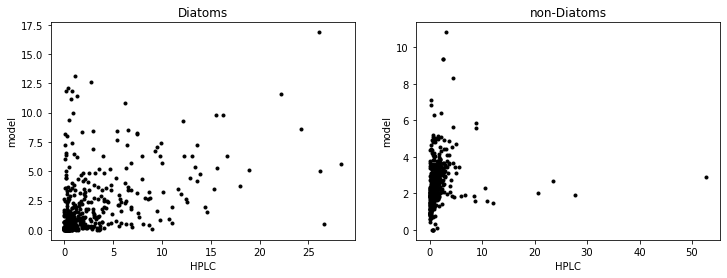

In [12]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(data['Diatoms-1']+data['Diatoms-2'],1.8*data['mod_diatoms'],'k.')
ax[0].set_title('Diatoms')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')

ax[1].plot(data['other'],1.8*(data['mod_flagellates']+data['mod_ciliates']),'k.')
ax[1].set_title('non-Diatoms')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')

(0, 8)

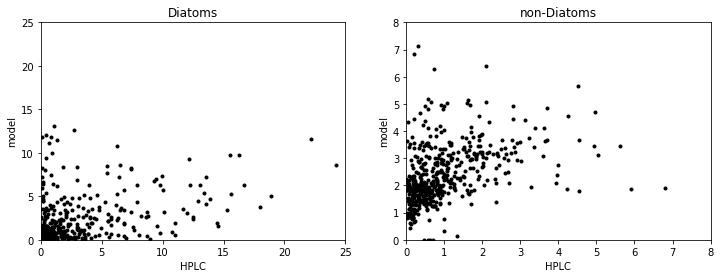

In [13]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(data['Diatoms-1']+data['Diatoms-2'],1.8*data['mod_diatoms'],'k.')
ax[0].set_title('Diatoms')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')
ax[0].set_xlim((0,25))
ax[0].set_ylim((0,25))
ax[1].plot(data['other'],1.8*(data['mod_flagellates']+data['mod_ciliates']),'k.')
ax[1].set_title('non-Diatoms')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')
ax[1].set_xlim((0,8))
ax[1].set_ylim((0,8))

In [14]:
def logt(x):
    return np.log(x+.001)

Text(0, 0.5, 'model')

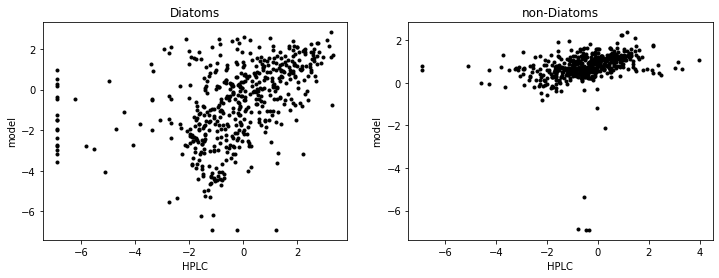

In [15]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(logt(data['Diatoms-1']+data['Diatoms-2']),logt(1.8*data['mod_diatoms']),'k.')
ax[0].set_title('Diatoms')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')

ax[1].plot(logt(data['other']),logt(1.8*(data['mod_flagellates']+data['mod_ciliates'])),'k.')
ax[1].set_title('non-Diatoms')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')

(-4, 3)

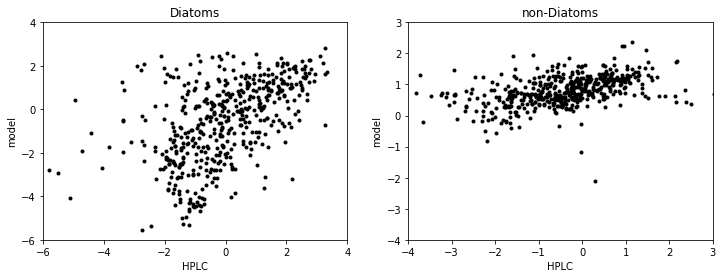

In [16]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(logt(data['Diatoms-1']+data['Diatoms-2']),logt(1.8*data['mod_diatoms']),'k.')
ax[0].set_title('Diatoms')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')
ax[0].set_xlim((-6,4))
ax[0].set_ylim((-6,4))
ax[1].plot(logt(data['other']),logt(1.8*(data['mod_flagellates']+data['mod_ciliates'])),'k.')
ax[1].set_title('non-Diatoms')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')
ax[1].set_xlim((-4,3))
ax[1].set_ylim((-4,3))

Text(0, 0.5, 'model')

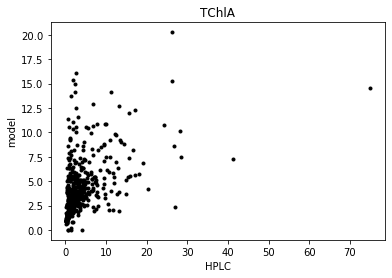

In [17]:
plt.plot(data['TchlA (ug/L)'],1.8*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms']),'k.')
plt.title('TChlA')
plt.xlabel('HPLC')
plt.ylabel('model')

Text(0, 0.5, 'model')

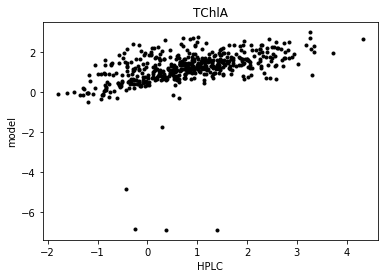

In [18]:
plt.plot(logt(data['TchlA (ug/L)']),logt(1.8*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms'])),'k.')
plt.title('TChlA')
plt.xlabel('HPLC')
plt.ylabel('model')

In [19]:
def yd(idt):
    if type(idt)==dt.datetime:
        yd=(idt-dt.datetime(idt.year-1,12,31)).days
    else: # assume array or pandas
        yd=[(ii-dt.datetime(ii.year-1,12,31)).days for ii in idt]
    return yd

In [20]:
data['yd']=yd(data['dtUTC'])

In [21]:
data['Year']=[ii.year for ii in data['dtUTC']]

In [22]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

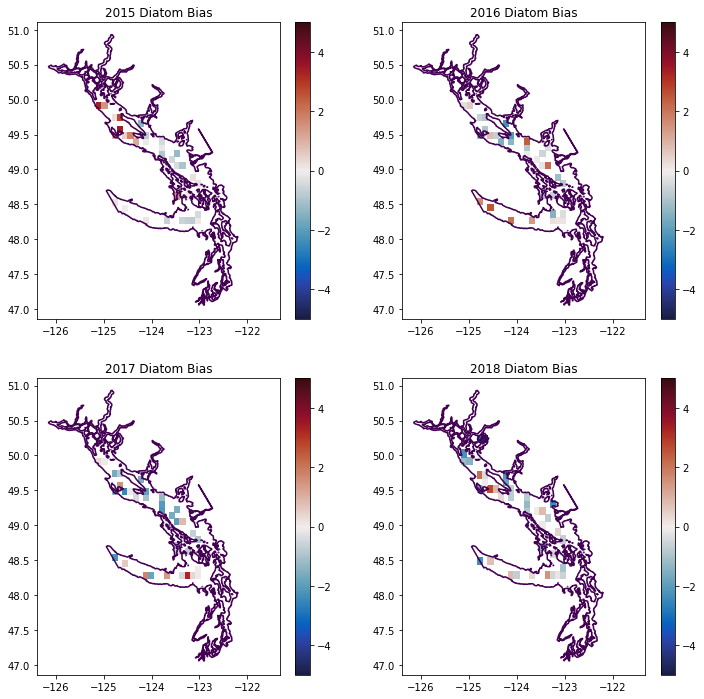

In [25]:
fig,ax=plt.subplots(2,2,figsize=(12,12))
ax=ax.flatten()
for yr in range(2015,2019):
    dyr=data.loc[(data['Year']==yr)&(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&~np.isnan(data['other'])&~np.isnan(data['mod_diatoms'])]
    ax[yr-2015].contour(navlon,navlat,tmask[0,:,:],(0.5,))
    ax[yr-2015].set_title(str(yr)+' Diatom Bias')
    s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
                logt(1.8*dyr['mod_diatoms'])-logt(dyr['Diatoms-1']+dyr['Diatoms-2']), 
                statistic='mean', bins=20)
    m=ax[yr-2015].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-5,vmax=5,shading='flat')
    plt.colorbar(m,ax=ax[yr-2015])

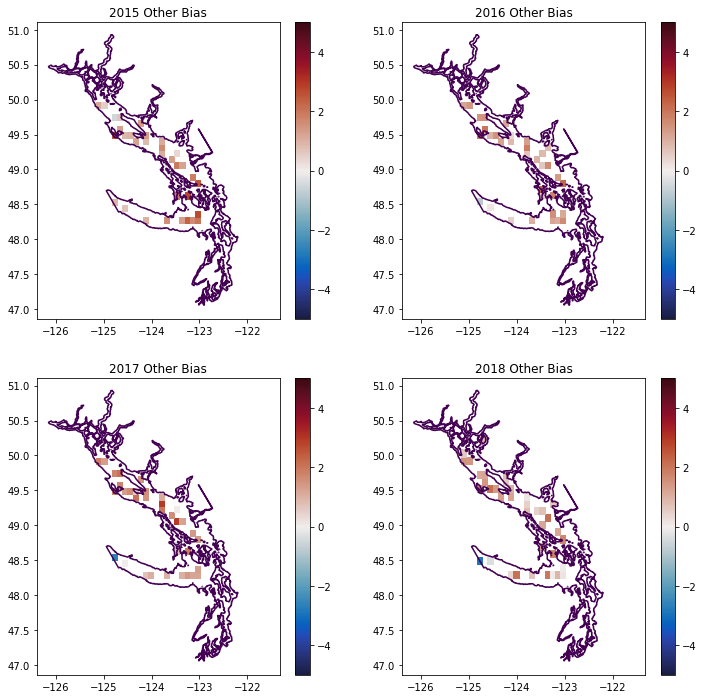

In [26]:
fig,ax=plt.subplots(2,2,figsize=(12,12))
ax=ax.flatten()
for yr in range(2015,2019):
    dyr=data.loc[(data['Year']==yr)&(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&~np.isnan(data['other'])&~np.isnan(data['mod_diatoms'])]
    ax[yr-2015].contour(navlon,navlat,tmask[0,:,:],(0.5,))
    ax[yr-2015].set_title(str(yr)+' Other Bias')
    s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
                logt(1.8*(dyr['mod_flagellates']+dyr['mod_ciliates']))-logt(dyr['other']), 
                statistic='mean', bins=20)
    m=ax[yr-2015].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-5,vmax=5,shading='flat')
    plt.colorbar(m,ax=ax[yr-2015])

Text(0, 0.5, 'log(mod)-log(hplc)')

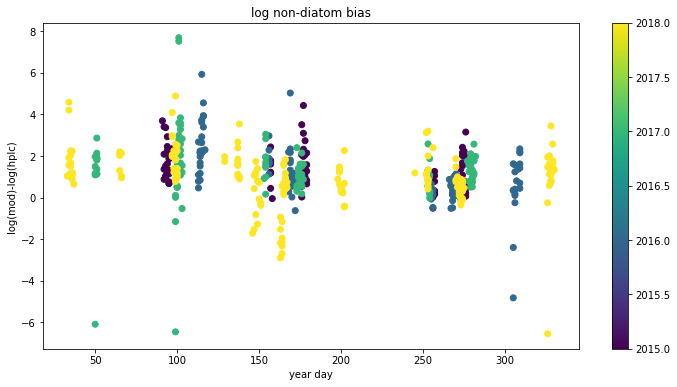

In [27]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
m=ax.scatter(data['yd'],logt(1.8*(data['mod_flagellates']+data['mod_ciliates']))-logt(data['other']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log non-diatom bias')
ax.set_xlabel('year day')
ax.set_ylabel('log(mod)-log(hplc)')

(-30, 25)

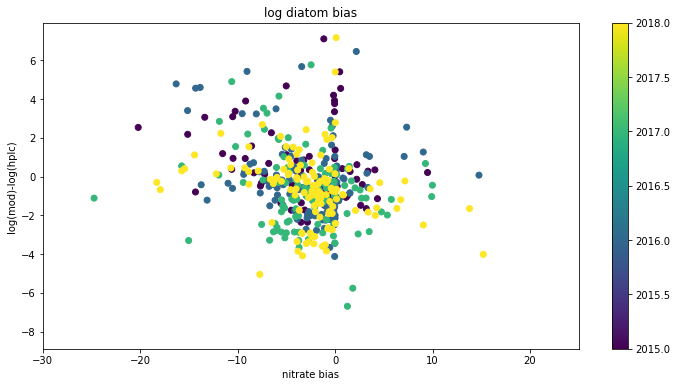

In [31]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
m=ax.scatter(data['mod_nitrate']-data['Nitrate_plus_Nitrite [umol/L]'],logt(1.8*data['mod_diatoms'])-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log diatom bias')
ax.set_xlabel('nitrate bias')
ax.set_ylabel('log(mod)-log(hplc)')
ax.set_xlim(-30,25)

(-1, 30)

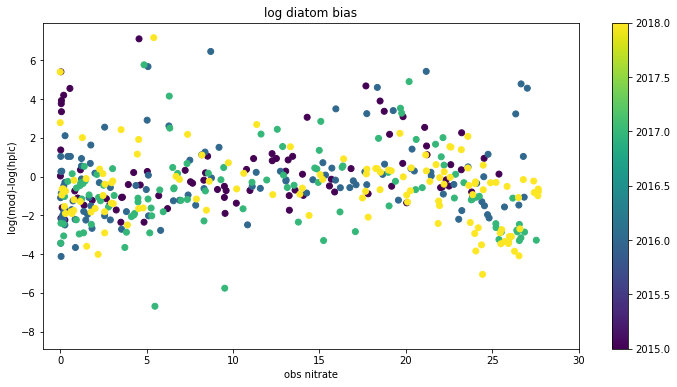

In [35]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
m=ax.scatter(data['Nitrate_plus_Nitrite [umol/L]'],logt(1.8*data['mod_diatoms'])-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log diatom bias')
ax.set_xlabel('obs nitrate')
ax.set_ylabel('log(mod)-log(hplc)')
ax.set_xlim(-1,30)

(-0.1, 3)

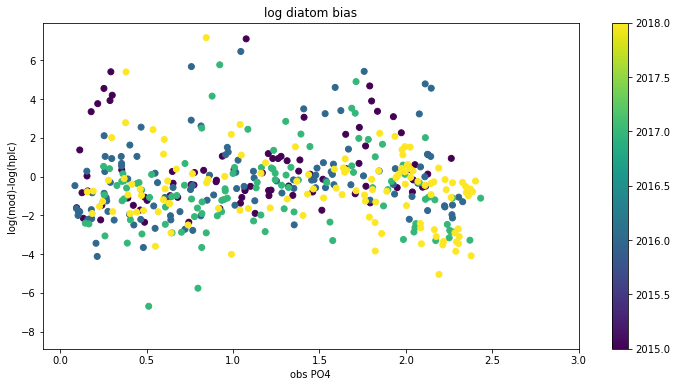

In [39]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
m=ax.scatter(data['Phosphate [umol/L]'],logt(1.8*data['mod_diatoms'])-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log diatom bias')
ax.set_xlabel('obs PO4')
ax.set_ylabel('log(mod)-log(hplc)')
ax.set_xlim(-.1,3)

(-1, 70)

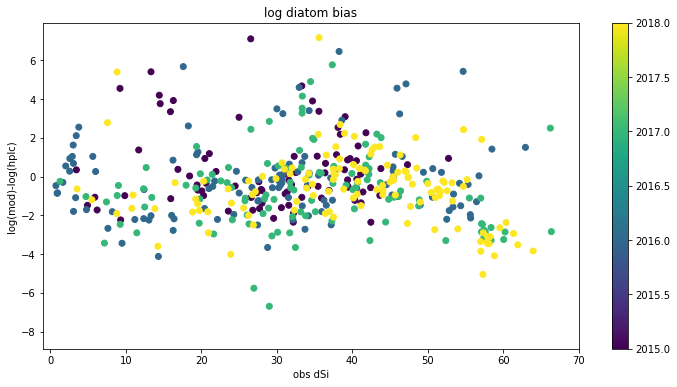

In [44]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
m=ax.scatter(data['Silicate [umol/L]'],logt(1.8*data['mod_diatoms'])-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log diatom bias')
ax.set_xlabel('obs dSi')
ax.set_ylabel('log(mod)-log(hplc)')
ax.set_xlim(-1,70)